In [119]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler,RobustScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

class PETNN(nn.Module):
    def __init__(self, input_size, hidden_size, cell_dim=5, T_init=1.0, hard_switch=True, Rt_bias = 1.5 , Zt_bias = 1.0, dropout =0.2 ,  forecast_horizon=24, head = 3):
        super().__init__()
        intermediate_dim = int(hidden_size * head)

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.cell_dim = cell_dim if cell_dim is not None else hidden_size

        self.forecast_horizon = forecast_horizon
        self.Rt_bias = Rt_bias
        self.Zt_bias = Zt_bias
        self.dropout = dropout

        self.T_init = T_init

        self.hard_switch = hard_switch

        self.WIt = nn.Linear(input_size, self.cell_dim)
        self.WZt = nn.Linear(input_size + hidden_size, self.cell_dim)
        self.WRt = nn.Linear(input_size, self.cell_dim)
        self.WZc = nn.Linear(input_size + hidden_size, self.cell_dim)
        self.WZw = nn.Linear(input_size + hidden_size, hidden_size)

        self.Wh = nn.Linear(input_size + hidden_size + self.cell_dim, hidden_size)

        self.ln_hidden = nn.LayerNorm(hidden_size)

        self.prediction_head = nn.Sequential(
            nn.Linear(hidden_size,intermediate_dim),
            nn.LayerNorm(intermediate_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(intermediate_dim, forecast_horizon))


        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
                    if module == self.WRt:
                        nn.init.constant_(module.bias, self.Rt_bias)
                    elif module == self.WZt:
                        nn.init.constant_(module.bias, self.Zt_bias)

    def forward(self, x):

        batch_size, seq_len, _ = x.shape
        device = x.device

        S_prev = torch.zeros(batch_size, self.hidden_size, device=device)
        T_prev = torch.full((batch_size, self.cell_dim), self.T_init, device=device)
        C_prev = torch.zeros(batch_size, self.cell_dim, device=device)

        total_resets = 0

        for t in range(seq_len):
            X_t = x[:, t, :]
            S_prev, C_prev, T_prev, num_resets = self.update_step(X_t, S_prev, C_prev, T_prev)
            total_resets += num_resets

        predictions = self.prediction_head(S_prev)

        return predictions, total_resets

    def update_step(self, X_t, S_prev, C_prev, T_prev ):

        Rt = F.softplus(self.WRt(X_t))
        Rt = torch.clamp(Rt, max=5.0)

        concat_input = torch.cat([X_t, S_prev], dim=-1)

        Zt = self.WZt(concat_input)
        Zc = self.WZc(concat_input)
        Zw = self.WZw(concat_input)

        T_new = Rt * torch.sigmoid((T_prev + Zt)) - 1

        num_resets = 0

        if self.hard_switch:
            m = (T_new < 0).float()
            num_resets = (T_new < 0).sum().item()
            T_new = T_new.clamp(min=0)

        else:
            m = torch.sigmoid(T_new)

        C_new = (1 - m) * C_prev + m * It + Zc
        C_modulated = (1 - m) * C_prev

        h_input = torch.cat([X_t, S_prev, C_modulated], dim=-1)

        h_input = self.Wh(h_input)

        h_state = torch.sigmoid(h_input)

        state_update = (1 - Zw) * S_prev + Zw * h_state
        S_new = torch.sigmoid(state_update)

        return S_new, C_new, T_new, num_resets

def plot_timeseries(df, features, time_col='date'):
    fig, axes = plt.subplots(4, 2, figsize=(15, 16))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        axes[i].plot(df[time_col], df[feature], linewidth=0.8, alpha=0.8)
        axes[i].set_title(f'{feature} over time', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(feature)
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)

        mean_val = df[feature].mean()
        axes[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
        axes[i].legend()

    if len(features) < len(axes):
        for j in range(len(features), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def compute_zscore(column):

    mean = np.mean(column)
    std_dev = np.std(column)
    zscore_column = (column - mean) / std_dev
    return zscore_column

def create_sequences(data, seq_length, pred_length, target_col_name):
    X, y = [], []

    target_index = data.columns.get_loc(target_col_name)
    data_array = data.values.astype(np.float32)

    for i in range(len(data_array) - seq_length - pred_length + 1):
        X.append(data_array[i:i+seq_length])
        y.append(data_array[i+seq_length:i+seq_length+pred_length, target_index])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    if y.ndim == 1:
        y = y.reshape(-1, 1)

    return X, y, target_index


def create_loaders(data, seq_length, pred_length, batch_size=32, target_col_name='target', exclude_scale_cols=[]):

    total_len = len(data)
    train_size = int(0.7 * total_len)
    val_size = int(0.15 * total_len)

    target_col_index = data.columns.get_loc(target_col_name)

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size:train_size + val_size]
    test_data = data.iloc[train_size + val_size:]

    feature_cols = [col for col in data.columns if col not in exclude_scale_cols and col != target_col_name]

    feature_scaler = RobustScaler()
    feature_scaler.fit(train_data[feature_cols])

    target_scaler = RobustScaler()
    target_scaler.fit(train_data[[target_col_name]])

    train_scaled = train_data.copy()
    val_scaled = val_data.copy()
    test_scaled = test_data.copy()

    train_scaled[feature_cols] = feature_scaler.transform(train_data[feature_cols])
    val_scaled[feature_cols] = feature_scaler.transform(val_data[feature_cols])
    test_scaled[feature_cols] = feature_scaler.transform(test_data[feature_cols])

    train_scaled[target_col_name] = target_scaler.transform(train_data[[target_col_name]])
    val_scaled[target_col_name] = target_scaler.transform(val_data[[target_col_name]])
    test_scaled[target_col_name] = target_scaler.transform(test_data[[target_col_name]])

    X_train, y_train, _ = create_sequences(train_scaled, seq_length, pred_length, target_col_name)
    X_val, y_val, _ = create_sequences(val_scaled, seq_length, pred_length, target_col_name)
    X_test, y_test, _ = create_sequences(test_scaled, seq_length, pred_length, target_col_name)

    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.FloatTensor(y_val)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

    return train_loader, val_loader, test_loader, target_scaler, target_col_index

def one_epoch(model, train_loader, val_loader, optimizer, criterion, device):

    model.train()
    train_loss = 0
    total_releases = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, releases = model(data)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

        if isinstance(releases, torch.Tensor):
             total_releases += releases.item()
        else:
             total_releases += releases

    model.eval()

    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_releases = total_releases / len(train_loader)

    return avg_train_loss, avg_val_loss, avg_releases

def test_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs, _ = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    return total_loss / len(test_loader)

def evaluate_model(model, data_loader, target_scaler, device):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs, _ = model(X_batch)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(y_batch.numpy())
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    pred_shape = predictions.shape
    predictions_flat = predictions.reshape(-1, 1)
    targets_flat = targets.reshape(-1, 1)

    predictions_original = target_scaler.inverse_transform(predictions_flat)
    targets_original = target_scaler.inverse_transform(targets_flat)

    predictions_original = predictions_original.reshape(pred_shape)
    targets_original = targets_original.reshape(pred_shape)

    mse = mean_squared_error(targets_original, predictions_original)
    mae = mean_absolute_error(targets_original, predictions_original)

    rmse = np.sqrt(mse)
    print(f"MSE={mse}")
    print(f"MAE={mae}")
    print(f"RMSE={rmse}")


    return {'predictions': predictions_original,'targets': targets_original}


def plot_residuals_distribution(result):

  n = len(result["predictions"])
  residuals = []
  for i in range(n):
      residual = result["targets"][i] - result["predictions"][i]
      residuals.append(residual)

  residuals_original = np.array(residuals)

  residuals_rounded = np.round(residuals_original).astype(int)

  plt.figure(figsize=(14, 6))
  plt.hist(residuals_rounded.flatten(), bins=50, edgecolor='black', alpha=0.7)

  plt.title("Distribution of Residuals")
  plt.xlabel("Residual")
  plt.ylabel("Frequency")
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

  return residuals_original

In [ ]:
!pip install optuna

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv")

df['date'] = pd.to_datetime(df['date'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']])
scaled_df = pd.DataFrame(scaled_data, columns=['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'])

for feature in ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']:
    print(f"{feature}: [{df[feature].min():.2f}, {df[feature].max():.2f}]")

scaled_df['day_of_week'] = df['date'].dt.dayofweek
scaled_df['month'] = df['date'].dt.month

day_onehot = pd.get_dummies(scaled_df['day_of_week'], prefix='day', dtype=np.float32)
month_onehot = pd.get_dummies(scaled_df['month'], prefix='month', dtype=np.float32)

final_data = pd.concat([scaled_df[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']],day_onehot, month_onehot], axis=1)
final_data = final_data.astype(np.float32)

HUFL: [0.00, 107.89]
HULL: [-29.32, 36.44]
MUFL: [10.43, 93.23]
MULL: [-6.65, 29.81]
LUFL: [-14.62, 17.22]
LULL: [-31.46, 3.73]
OT: [-2.65, 58.88]


In [ ]:
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

print(df[['date', 'hour', 'minute', 'day_of_week']].head(20))

                  date  hour  minute  day_of_week
0  2016-07-01 00:00:00     0       0            4
1  2016-07-01 00:15:00     0      15            4
2  2016-07-01 00:30:00     0      30            4
3  2016-07-01 00:45:00     0      45            4
4  2016-07-01 01:00:00     1       0            4
5  2016-07-01 01:15:00     1      15            4
6  2016-07-01 01:30:00     1      30            4
7  2016-07-01 01:45:00     1      45            4
8  2016-07-01 02:00:00     2       0            4
9  2016-07-01 02:15:00     2      15            4
10 2016-07-01 02:30:00     2      30            4
11 2016-07-01 02:45:00     2      45            4
12 2016-07-01 03:00:00     3       0            4
13 2016-07-01 03:15:00     3      15            4
14 2016-07-01 03:30:00     3      30            4
15 2016-07-01 03:45:00     3      45            4
16 2016-07-01 04:00:00     4       0            4
17 2016-07-01 04:15:00     4      15            4
18 2016-07-01 04:30:00     4      30            4


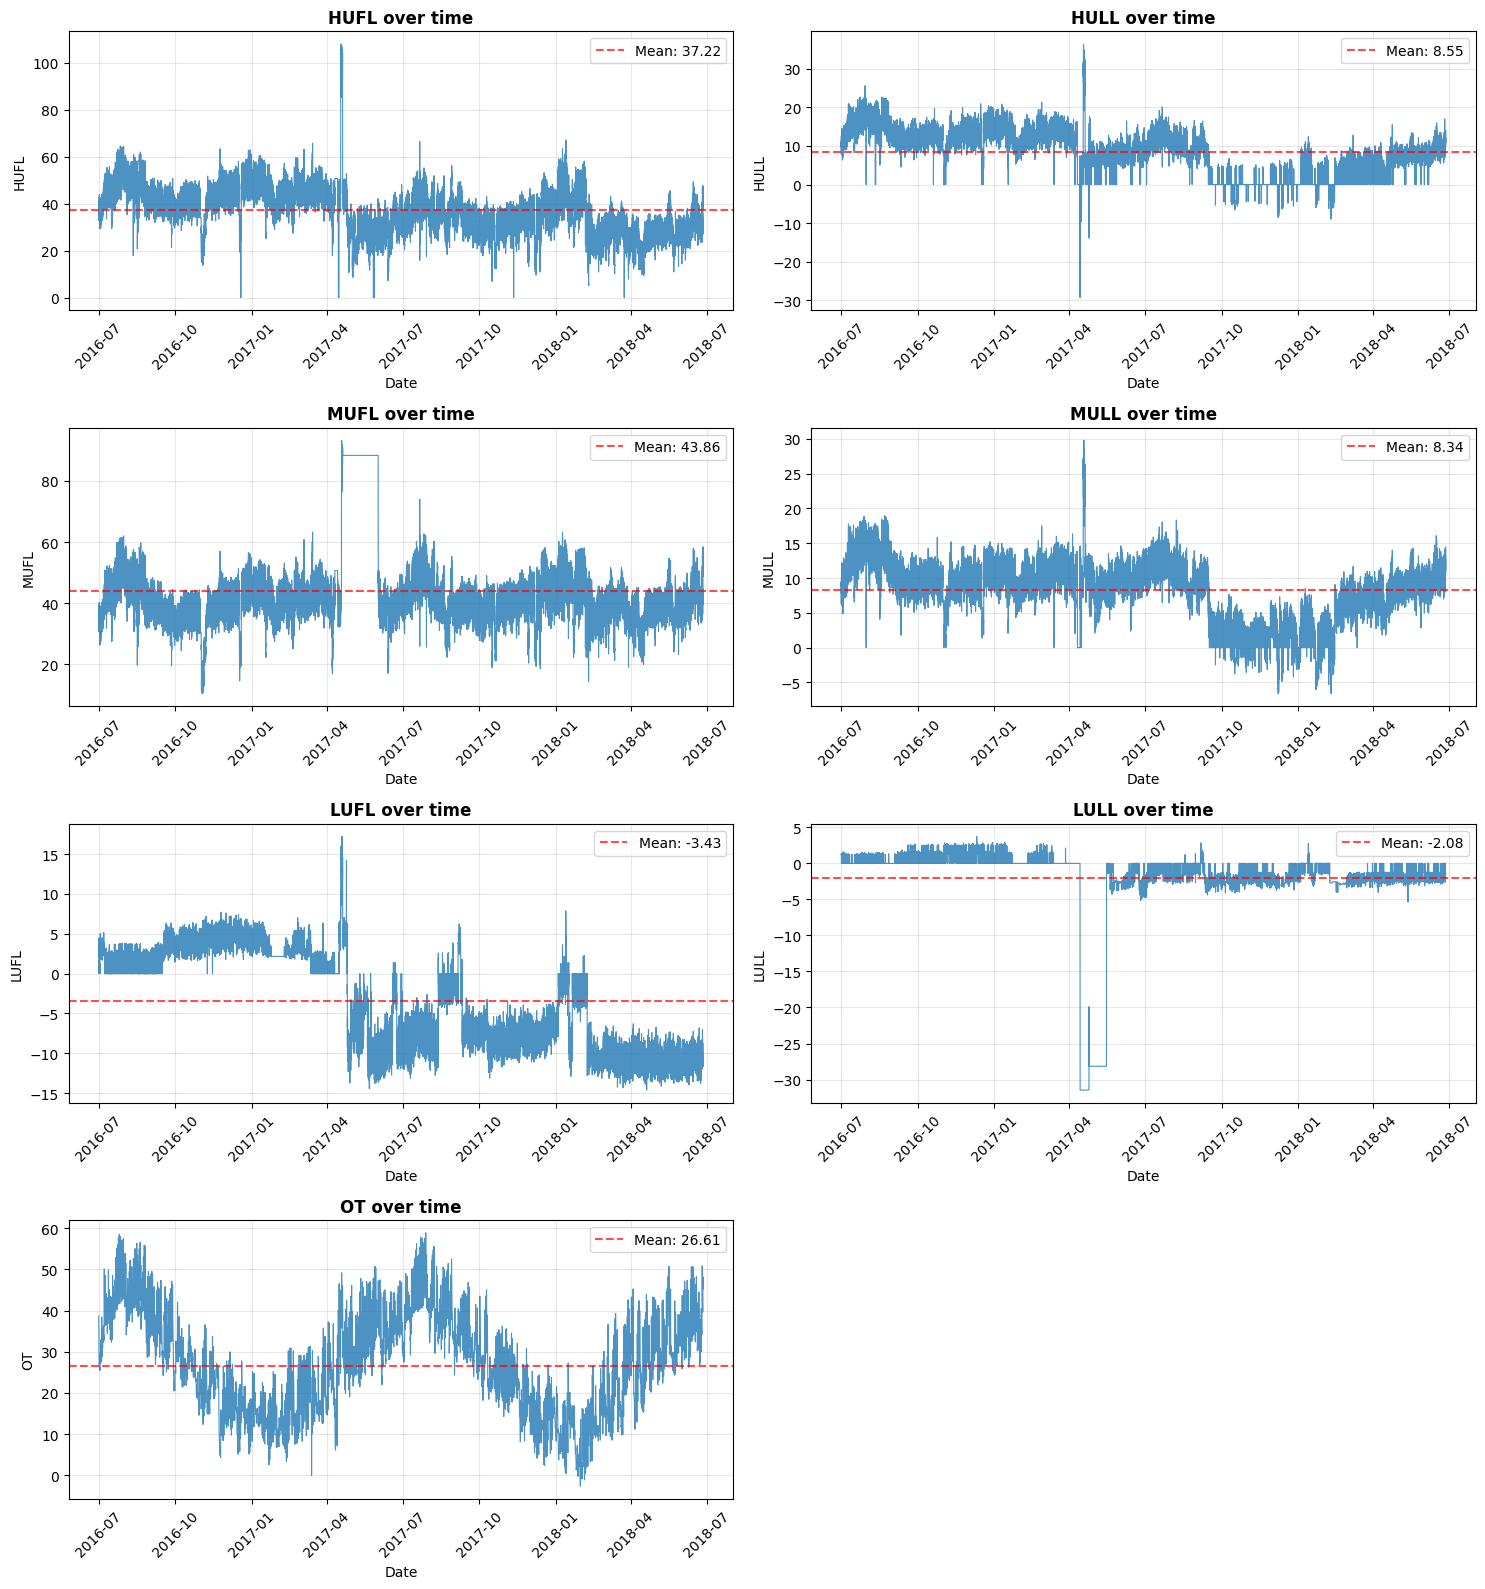

In [ ]:
features = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
plot_timeseries(df, features)


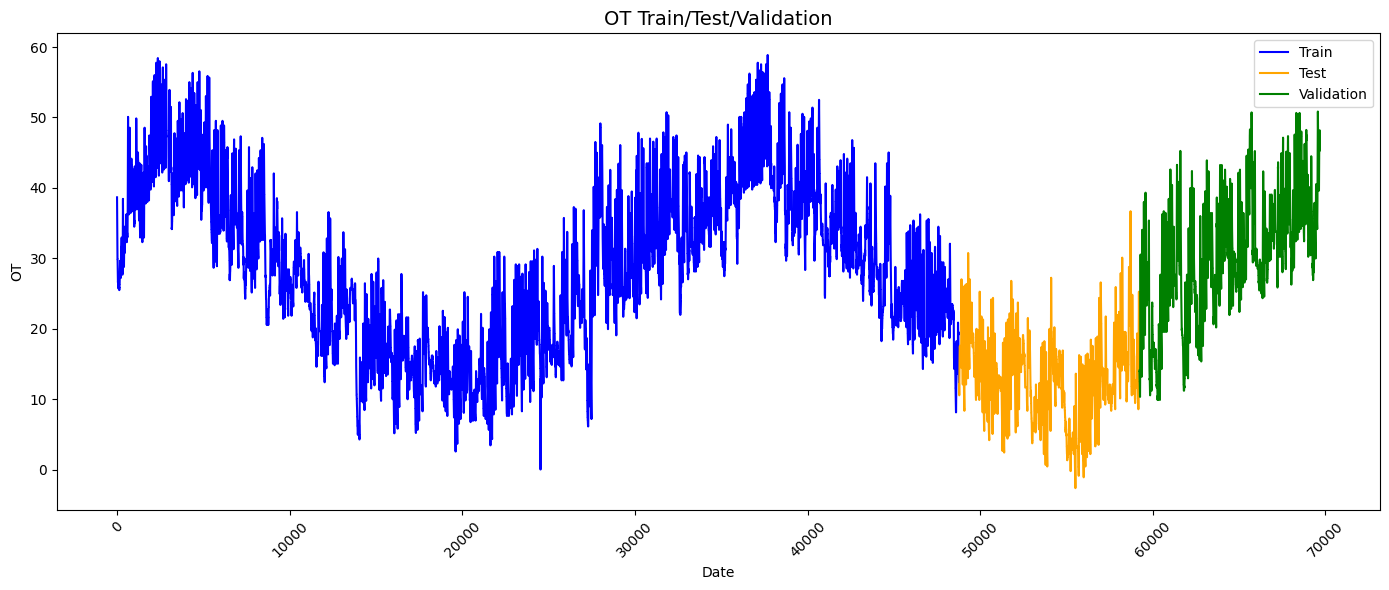

In [ ]:
import seaborn as sns

total_len = len(df)
train_size = int(0.7 * total_len)
val_size = int(0.15 * total_len)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:train_size + val_size]
val_data = df.iloc[train_size + val_size:]

plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data["OT"], label='Train', color='blue', linewidth=1.5)
plt.plot(test_data.index, test_data["OT"], label='Test', color='orange', linewidth=1.5)
plt.plot(val_data.index, val_data["OT"], label='Validation', color='green', linewidth=1.5)
plt.title("OT Train/Test/Validation", fontsize=14)
plt.xlabel("Date")
plt.ylabel("OT")
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_no_date = df.drop(columns=["date"])
features = [col for col in df_no_date.columns if col != 'OT']

feature_scaler = RobustScaler()
scaled_features = feature_scaler.fit_transform(df_no_date[features])

target_scaler = RobustScaler()
scaled_target = target_scaler.fit_transform(df_no_date[['OT']])

scaled_df = pd.DataFrame(np.concatenate([scaled_features, scaled_target], axis=1),columns=features + ['OT'],index=df.index)

scaled_df['date'] = df['date']

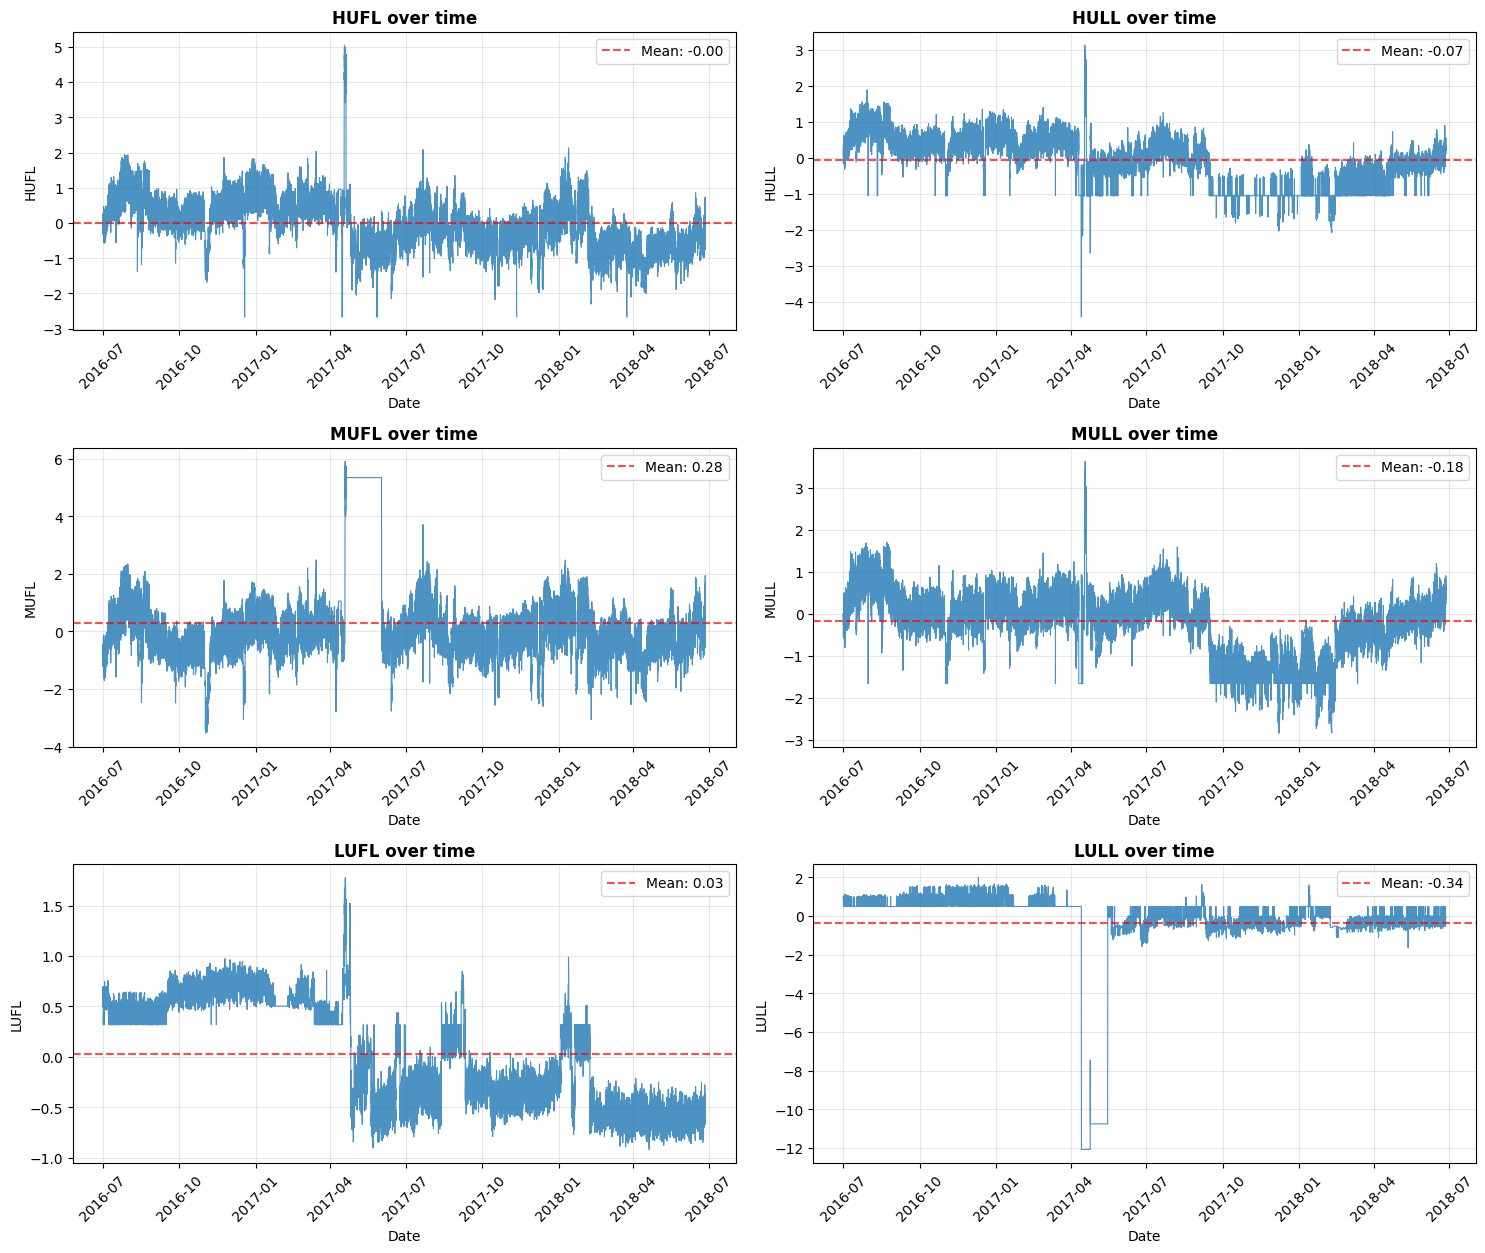

In [ ]:
plot_timeseries(scaled_df, features)

In [ ]:
seq_length = 96
pred_length = 96
batch_size = 32

train_loader, val_loader, test_loader, scaler, target_idx = create_loaders(final_data, seq_length=seq_length, pred_length=pred_length, batch_size=batch_size, target_col_name='OT')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_batch = next(iter(train_loader))
input_size = sample_batch[0].shape[-1]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from itertools import product

param_grid = {'switch': [True],'weight_decay': [0.0005],'bias_R': [4.75 , 4.5 ,4],'cell_dim': [32 , 48 , 64],'lr': [0.001] , "dropout" : [0.2]}

combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results = []

MIN_RELEASES = 0
MAX_RELEASES = 7000
idx = 0

for combo in combinations:

    params = dict(zip(param_names, combo))
    seed = 42 + idx
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seed {seed}")
    print(f"\nTesting: Wd={params['weight_decay']}, Cell={params['cell_dim']}, "
          f"Switch={params['switch']}, Bias_R={params['bias_R']}, Lr={params['lr']}, Dropout={params['dropout']}")


    model = PETNN(input_size=input_size,hidden_size=64,cell_dim=params['cell_dim'],hard_switch=params['switch'],Rt_bias=params['bias_R'],dropout=params["dropout"], forecast_horizon=pred_length).to(device)

    criterion =nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.Adam(model.parameters(),lr=params['lr'],weight_decay=params['weight_decay'])
    skipped = False
    num_epochs = 3
    for epoch_num in range(num_epochs):
        train_loss, val_loss, avg_releases = one_epoch(model, train_loader, val_loader, optimizer, criterion, device)

        if params['switch']:
            print(f"Epoch {epoch_num+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Avg Releases={avg_releases:.2f}")
        if avg_releases < MIN_RELEASES or avg_releases > MAX_RELEASES:
            print(f"  -> Skipping. Avg Releases ({avg_releases:.2f}) not in [{MIN_RELEASES}, {MAX_RELEASES}].")
            skipped = True
            break

    if not skipped:
        gap = train_loss - val_loss
        loss_final = val_loss + gap
        results.append({**params,'final_train_loss': train_loss,'final_val_loss': val_loss,'loss': loss_final})
    else:
        results.append({**params, 'loss': float('inf')})
    idx += 1
best_result = min(results, key=lambda x: x['loss'])

## Best Model Results (Seed 42)

This run achieved the lowest validation loss (Val Loss) of all trials, reaching **0.034864**.

### ⚙️ Hyperparameters
  {
        'Wd': 0.0005,
        'Cell': 32,
        'Switch': True,
        'Bias_R': 4.75,
        'Lr': 0.001,
        'Dropout': 0.2
    }
-----

### Performance (Loss) Evolution

| Epoch | Train Loss | Val Loss | Avg Releases |
| :--- | :--- | :--- | :--- |
| 1 | 0.045196 | 0.046234 | 1973.74 |
| 2 | 0.031290 | 0.045556 | 1978.96 |
| **3** | **0.027637** | **0.034864** | **1974.72** |



In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model_1 = PETNN(input_size=input_size,hidden_size=64,cell_dim=32,hard_switch=True,Rt_bias=4.75 ,dropout= 0.2, forecast_horizon=pred_length).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
patience = 3
patience_counter = 0

for epoch_num in range(15):
    train_loss, val_loss, avg_releases = one_epoch(model_1, train_loader, val_loader, optimizer, criterion, device)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch_num + 1
        best_model_state = {'epoch': epoch_num + 1,'model_state_dict': model_1.state_dict(),'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,'val_loss': val_loss,'avg_releases': avg_releases}
        torch.save(best_model_state, 'best_model.pth')
        patience_counter = 0
        print(f"New best!")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{patience})")

    print(f"Epoch {epoch_num+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Avg Releases={avg_releases:.2f}")
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch_num+1} epochs")
        break

print(f"\n=== Best model ===")
print(f"Epoch: {best_epoch}")
print(f"Train Loss: {best_model_state['train_loss']:.6f}")
print(f"Val Loss: {best_model_state['val_loss']:.6f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


New best!
Epoch 1: Train=0.220946, Val=0.229823, Avg Releases=2047.50
No improvement (1/3)
Epoch 2: Train=0.184273, Val=0.232881, Avg Releases=2004.11
New best!
Epoch 3: Train=0.174102, Val=0.211245, Avg Releases=2017.97
New best!
Epoch 4: Train=0.154613, Val=0.199764, Avg Releases=2014.77
New best!
Epoch 5: Train=0.144584, Val=0.192586, Avg Releases=2005.40
No improvement (1/3)
Epoch 6: Train=0.138992, Val=0.206794, Avg Releases=1986.02
No improvement (2/3)
Epoch 7: Train=0.134142, Val=0.201857, Avg Releases=1984.43
No improvement (3/3)
Epoch 8: Train=0.130635, Val=0.199330, Avg Releases=1980.06

Early stopping triggered after 8 epochs

=== Best model ===
Epoch: 5
Train Loss: 0.144584
Val Loss: 0.192586


In [ ]:
model_1.eval()
result = evaluate_model(model_1, test_loader, scaler, device)

## Model Performance

* **Train Loss:** 0.1446
* **Validation Loss:** 0.1926

---

## 📊 Test Set Evaluation

* **Mean of Residuals:** -2.5244
    * *Note: A non-zero mean indicates a systematic bias. The model consistently under predicts by approximately 2.52 units.*
* **MAE :** 3.5269
* **MSE :** 21.0583
* **RMSE :** 4.5889

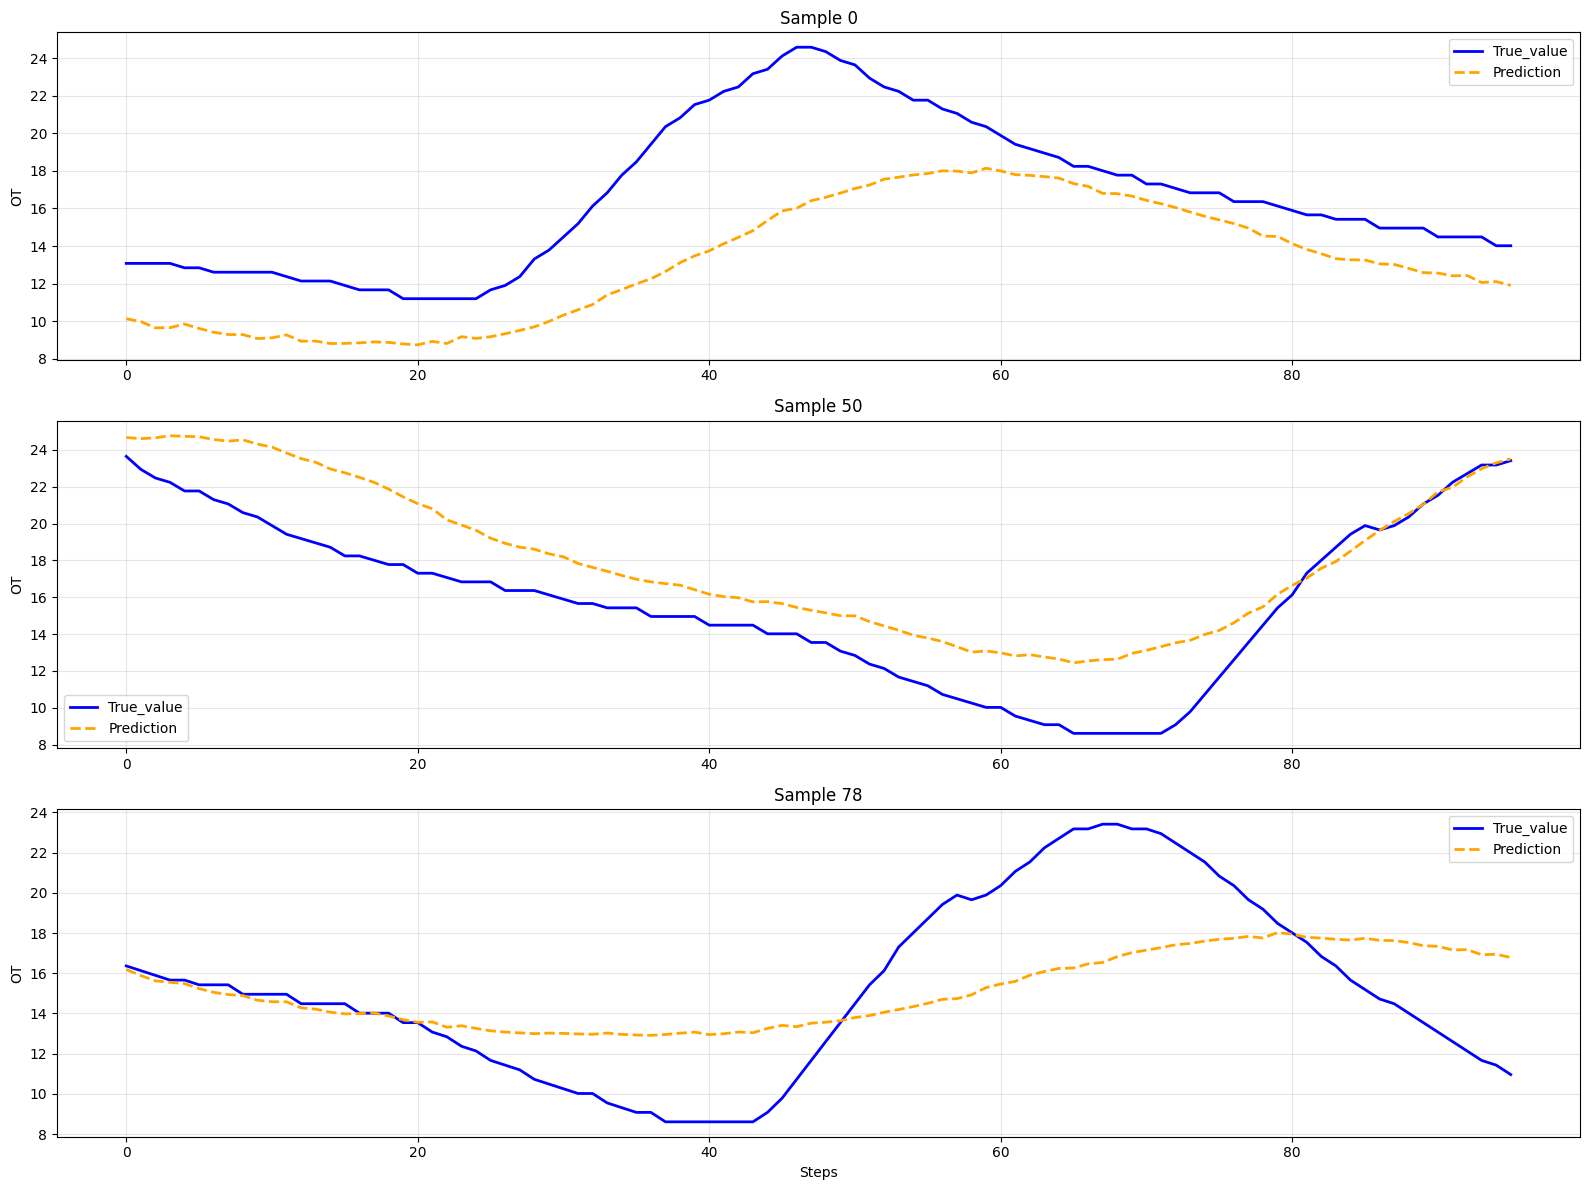

In [ ]:
indices_to_plot = [0 , 50 , 78]

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for i, idx in enumerate(indices_to_plot):
    if idx >= len(result["targets"]):
        print(f"Warning: index {idx} out of range")
        continue

    sample_y = result["targets"][idx].flatten()
    sample_y_pred = result["predictions"][idx].flatten()

    axes[i].plot(range(len(sample_y)), sample_y, label='True_value', color='blue', linewidth=2)
    axes[i].plot(range(len(sample_y_pred)), sample_y_pred, label='Prediction', color='orange', linewidth=2, linestyle='--')
    axes[i].set_title(f"Sample {idx}", fontsize=12)
    axes[i].set_ylabel("OT")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

axes[2].set_xlabel("Steps")
plt.tight_layout()
plt.show()

/tmp/ipython-input-1610383468.py:314: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


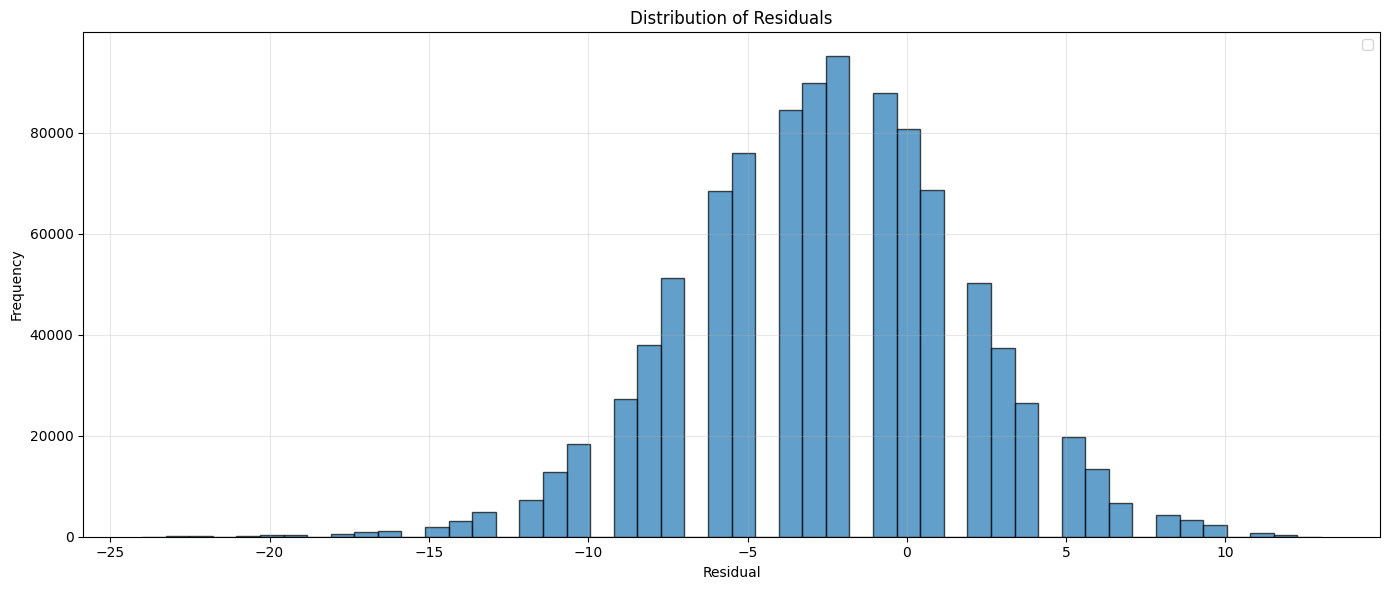

In [ ]:
residuals = plot_residuals_distribution(result)

## Result

The model shows promising results: the distribution of the residuals looks like a normal distribution, which validates the ARIMA hypothesis. However, the distribution is not fully centered around 0 but more around -2.5244. This is good information, indicating that the model slightly over estimates the values, and on the plot, we can see this tendency toward negative values

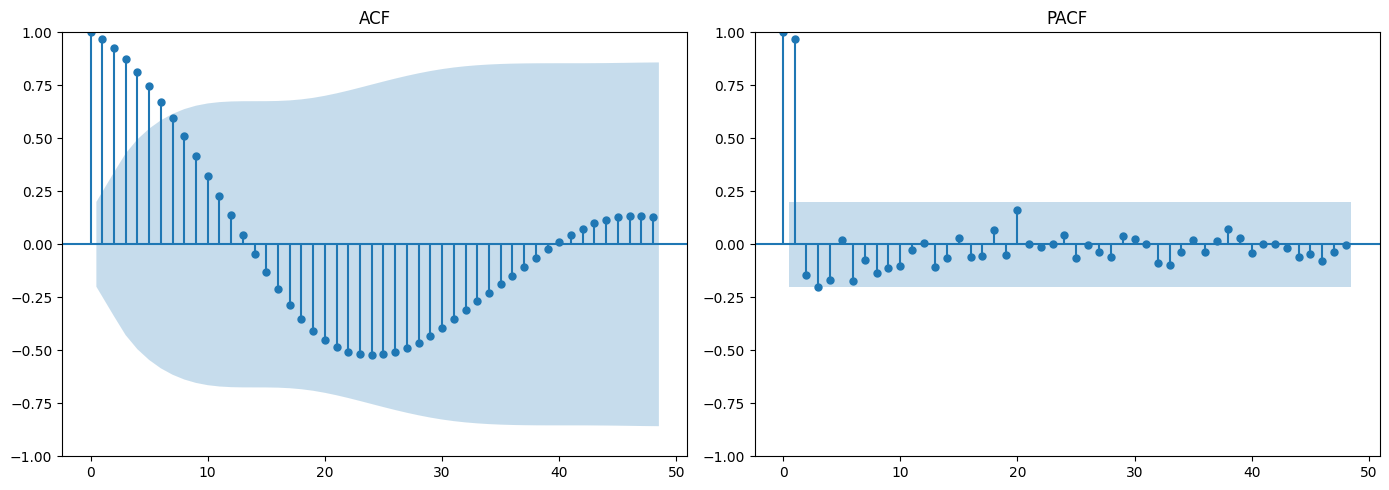

In [ ]:

def plot_autocorr_batch(predictions, targets, window_size=96):
    residuals = (targets - predictions).flatten()

    start_idx = np.random.randint(0, len(residuals) - window_size)
    residuals_batch = residuals[start_idx:start_idx + window_size]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    plot_acf(residuals_batch, lags=48, ax=axes[0])
    axes[0].set_title('ACF')

    plot_pacf(residuals_batch, lags=48, ax=axes[1])
    axes[1].set_title('PACF')

    plt.tight_layout()
    plt.show()

plot_autocorr_batch(results['predictions'], results['targets'])

## ACF diagnostic

The ACF graph shows that the model's errors are not random. This means the model is missing a pattern that could potentially be captured through better feature engineering or by using a different architecture.

In [ ]:
from itertools import product

param_grid = {'switch': [False],'weight_decay': [0.0005],'bias_R': [4.75 , 4.5 ,4],'cell_dim': [32 , 48 , 64],'lr': [0.001] , "dropout" : [0.2]}

combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results = []

idx = 0

for combo in combinations:

    params = dict(zip(param_names, combo))
    seed = 42 + idx
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seed {seed}")
    print(f"\nTesting: Wd={params['weight_decay']}, Cell={params['cell_dim']}, "
          f"Switch={params['switch']}, Bias_R={params['bias_R']}, Lr={params['lr']}, Dropout={params['dropout']}")


    model = PETNN(input_size=input_size,hidden_size=64,cell_dim=params['cell_dim'],hard_switch=params['switch'],Rt_bias=params['bias_R'],dropout=params["dropout"], forecast_horizon=pred_length).to(device)

    criterion =nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.Adam(model.parameters(),lr=params['lr'],weight_decay=params['weight_decay'])

    skipped = False
    num_epochs = 3
    for epoch_num in range(num_epochs):
        train_loss, val_loss, avg_releases = one_epoch(model, train_loader, val_loader, optimizer, criterion, device)
        print(f"Epoch {epoch_num+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Avg Releases={avg_releases:.2f}")

    if not skipped:
        gap = train_loss - val_loss
        loss_final = val_loss + gap
        results.append({**params,'final_train_loss': train_loss,'final_val_loss': val_loss,'loss': loss_final})
    else:
        results.append({**params, 'loss': float('inf')})
    idx += 1
best_result = min(results, key=lambda x: x['loss'])

Seed 42

Testing: Wd=0.0005, Cell=32, Switch=False, Bias_R=4.75, Lr=0.001, Dropout=0.2


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: Train=0.051777, Val=0.055031, Avg Releases=0.00
Epoch 2: Train=0.038846, Val=0.054876, Avg Releases=0.00
Epoch 3: Train=0.038729, Val=0.052356, Avg Releases=0.00
Seed 43

Testing: Wd=0.0005, Cell=48, Switch=False, Bias_R=4.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.050916, Val=0.052270, Avg Releases=0.00
Epoch 2: Train=0.038527, Val=0.056753, Avg Releases=0.00
Epoch 3: Train=0.038521, Val=0.053237, Avg Releases=0.00
Seed 44

Testing: Wd=0.0005, Cell=64, Switch=False, Bias_R=4.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.051795, Val=0.055215, Avg Releases=0.00
Epoch 2: Train=0.038392, Val=0.059756, Avg Releases=0.00
Epoch 3: Train=0.038392, Val=0.066685, Avg Releases=0.00
Seed 45

Testing: Wd=0.0005, Cell=32, Switch=False, Bias_R=4.5, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.050388, Val=0.050875, Avg Releases=0.00
Epoch 2: Train=0.038622, Val=0.052833, Avg Releases=0.00
Epoch 3: Train=0.038534, Val=0.053662, Avg Releases=0.00
Seed 46

Testing: Wd=0.0005, Cell=48, Switch=False, Bias

## Hard Switch vs Smooth Switch

The model performed significantly better before, when using the hard switch. This suggests that following the physics assumption meaning the physics inspired neural network is really important and the primary reason for the results shown.

However, this architecture suffers from the same issues as classical RNNs or LSTMs it is very slow to train, even though it is a small model. Given its performance, it can be discouraging to train it on large amounts of data.

In [178]:
df = pd.read_csv("https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv")

df['date'] = pd.to_datetime(df['date'])

for feature in ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']:
    print(f"{feature}: [{df[feature].min():.2f}, {df[feature].max():.2f}]")

df['day_cos'] = np.cos( (2 * np.pi *  df['date'].dt.dayofweek ) /  7 )
df['day_sin'] = np.sin( (2 * np.pi *  df['date'].dt.dayofweek ) /  7)

df['month_cos'] = np.cos( (2 * np.pi *  df['date'].dt.month ) / 12 )
df['month_sin'] = np.sin( (2 * np.pi *  df['date'].dt.month ) / 12 )

df['hour_cos'] = np.cos( (2 * np.pi *  df['date'].dt.hour ) / 24 )
df['hour_sin'] = np.sin( (2 * np.pi *  df['date'].dt.hour ) / 24 )

df['minute_cos'] = np.cos( (2 * np.pi *  df['date'].dt.minute ) / 60 )
df['minute_sin'] = np.sin( (2 * np.pi *  df['date'].dt.minute ) / 60 )

HUFL: [0.00, 107.89]
HULL: [-29.32, 36.44]
MUFL: [10.43, 93.23]
MULL: [-6.65, 29.81]
LUFL: [-14.62, 17.22]
LULL: [-31.46, 3.73]
OT: [-2.65, 58.88]


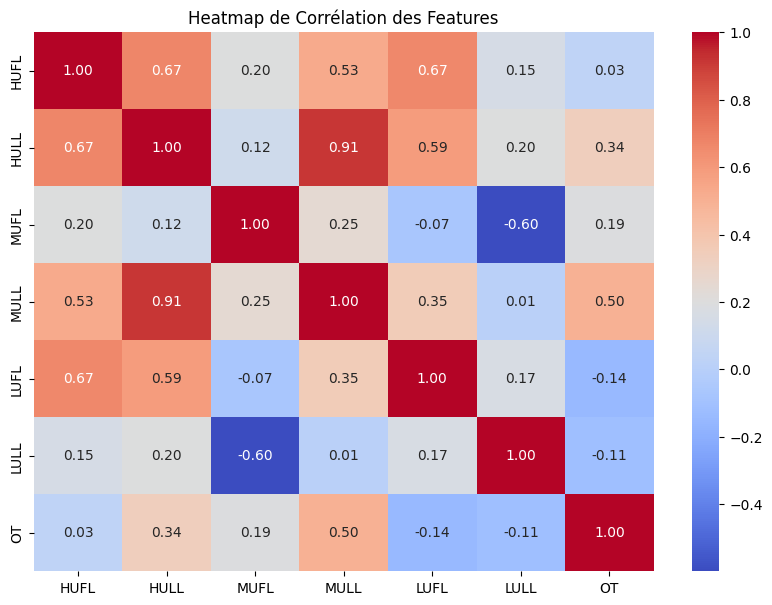

In [71]:
features_a_tester = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL',"OT"]
df_features = df[features_a_tester]

corr_matrix = df_features.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True,cmap='coolwarm',fmt='.2f')
plt.show()

This code applies a double smoothing (median then mean) to each variable to reduce noise and outliers.  
The median filter removes sharp spikes, while the mean filter smooths remaining fluctuations.  
The result is a cleaner signal that preserves the overall trend of the data.


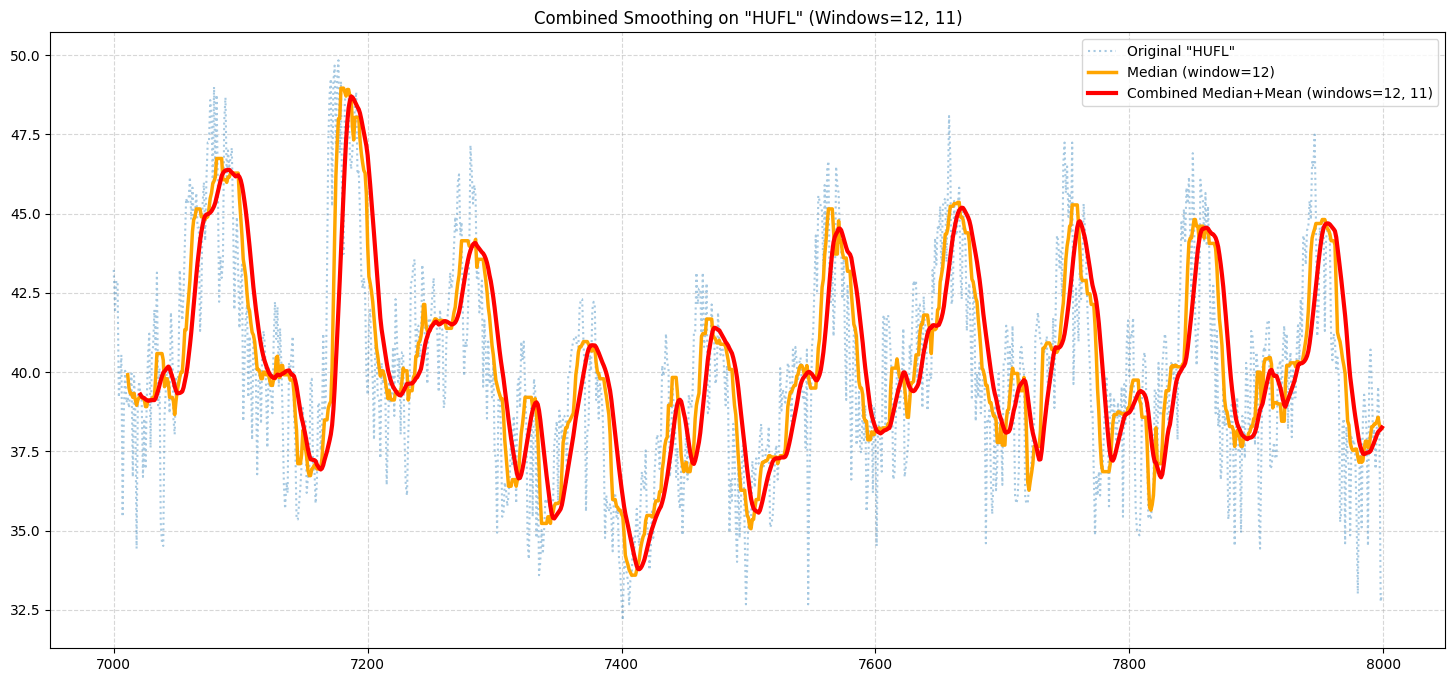

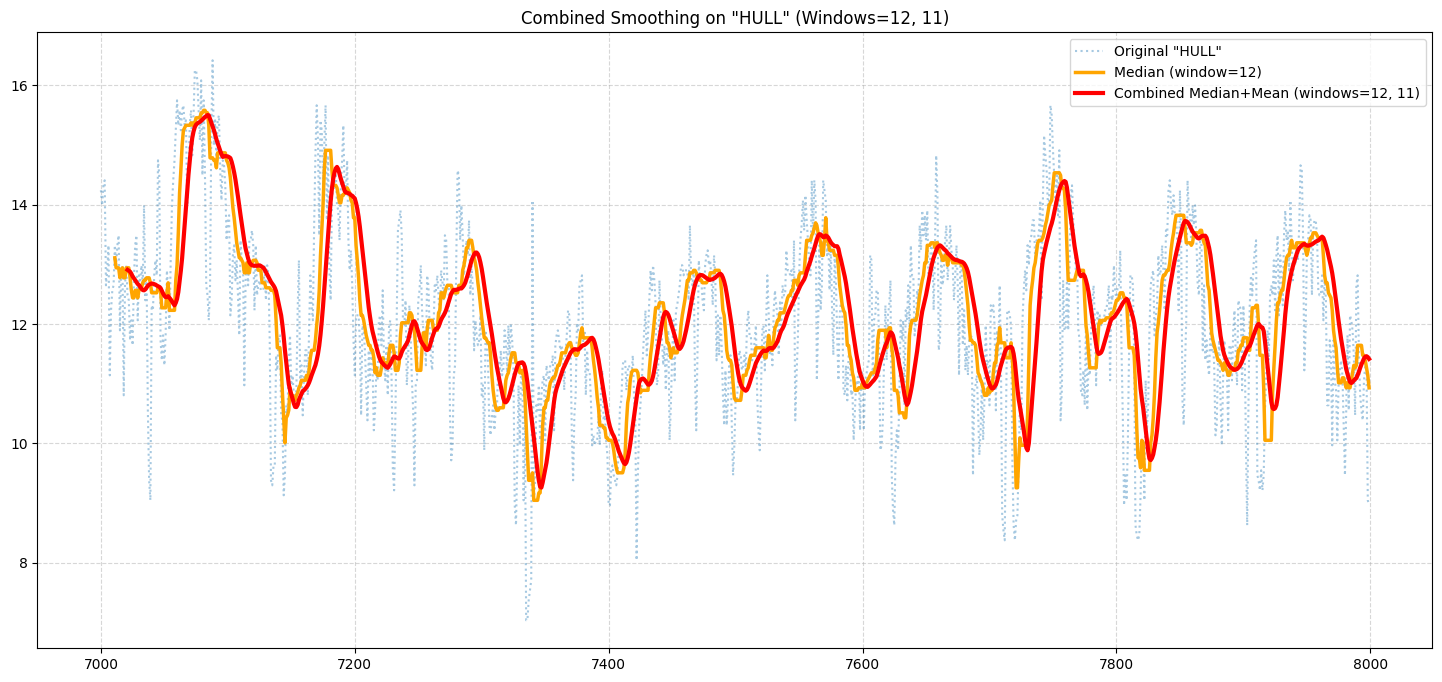

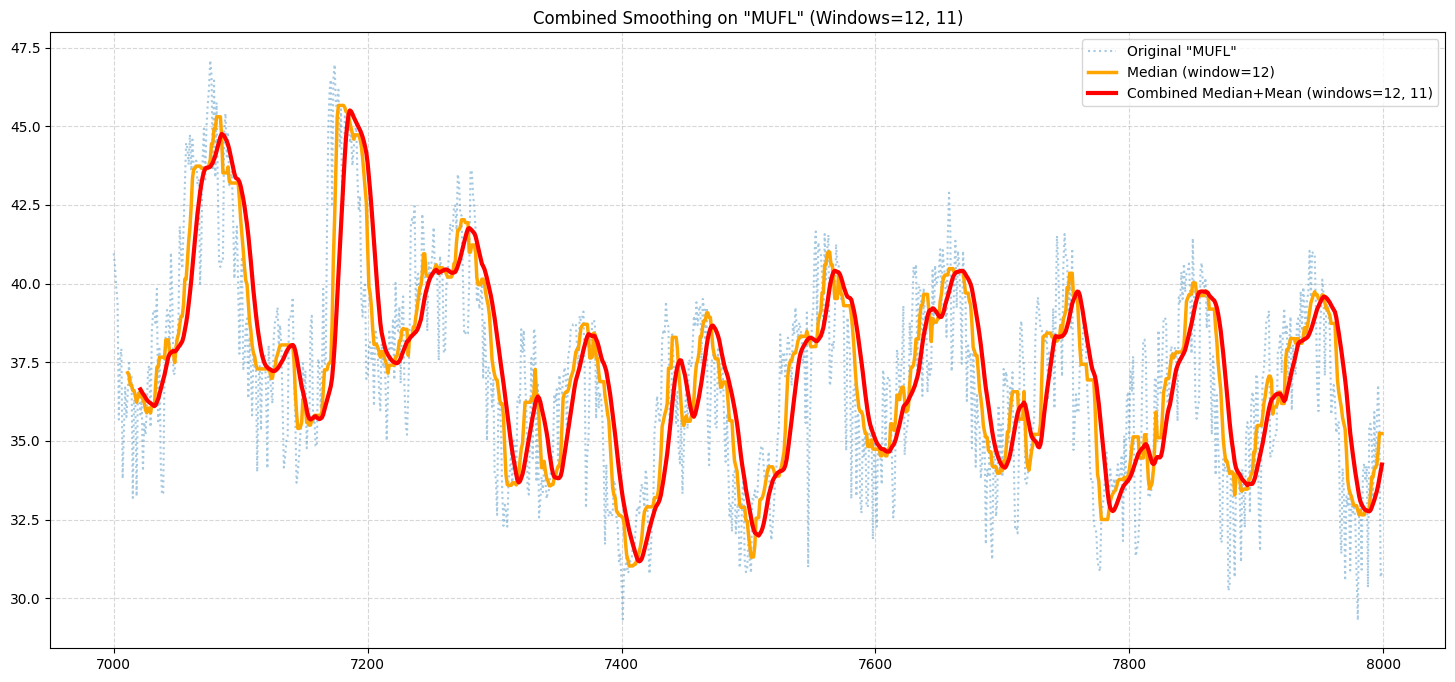

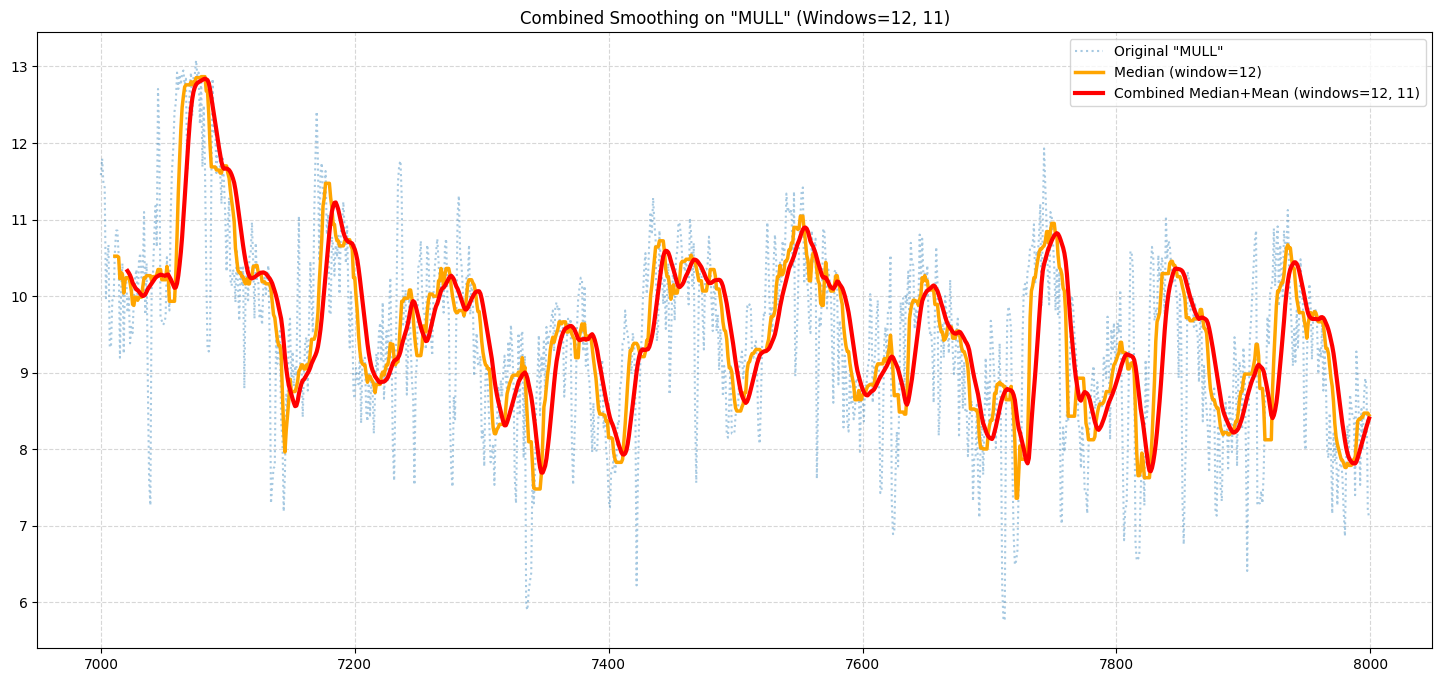

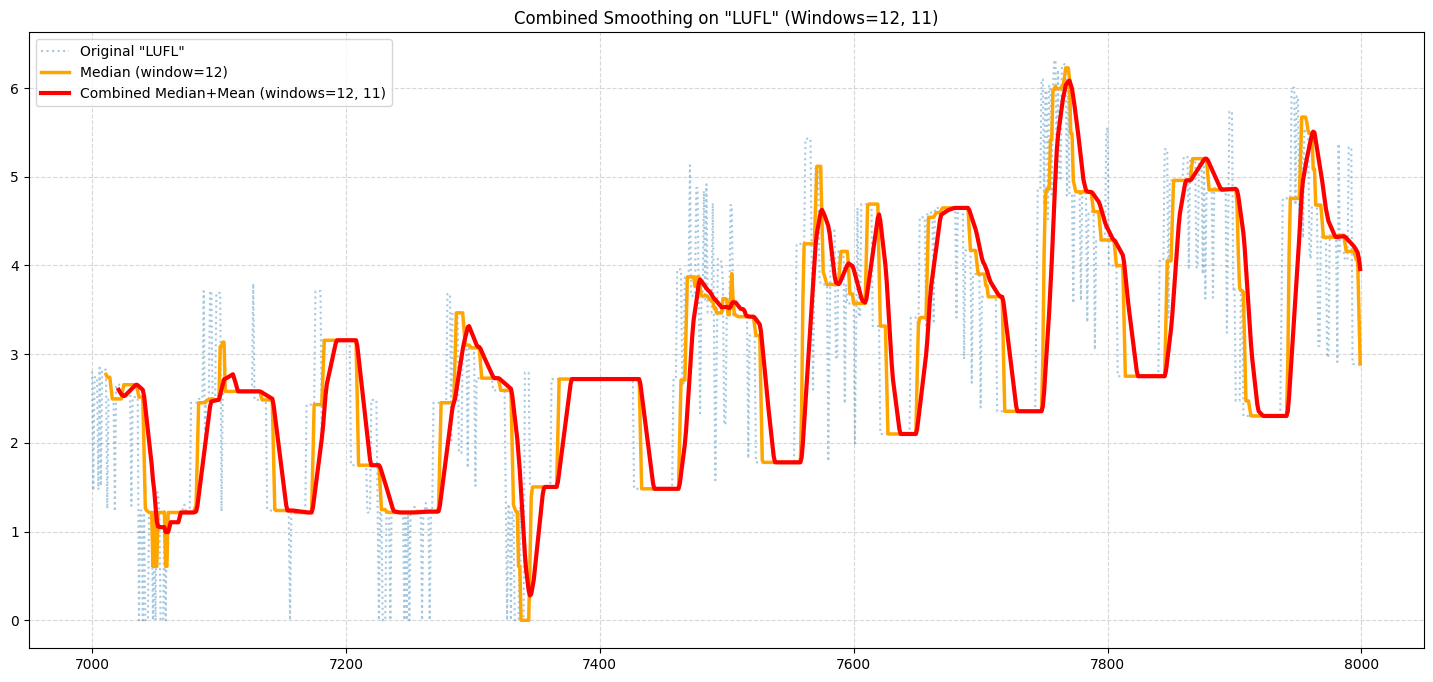

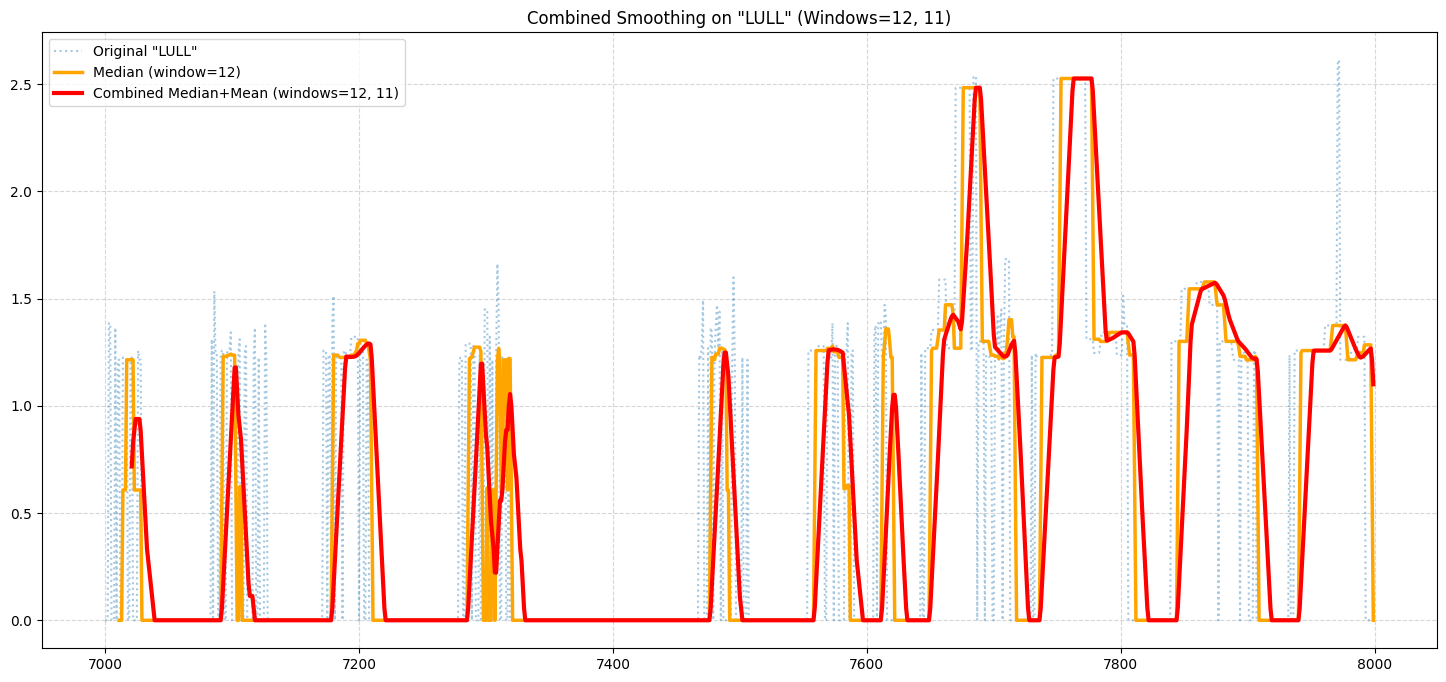

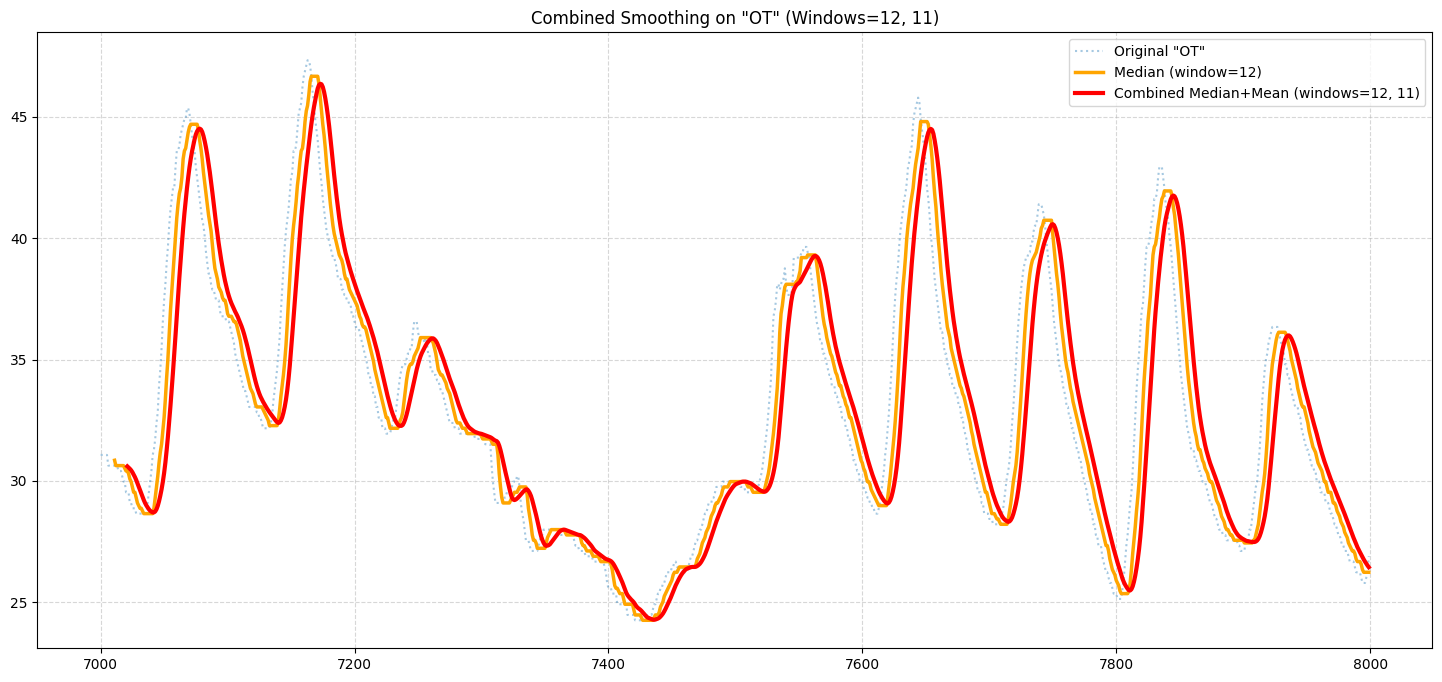

In [109]:
MEDIAN_WINDOW = 12
MEAN_WINDOW = 11

features_to_plot = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

df_plot = df.iloc[7000:8000].copy()

for feature in features_to_plot:
    median_col_name = f'{feature}_median'
    df_plot[median_col_name] = df_plot[feature].rolling(window=MEDIAN_WINDOW, center=False).median()

    combined_col_name = f'{feature}_median_mean'
    df_plot[combined_col_name] = df_plot[median_col_name].rolling(window=MEAN_WINDOW, center=False).mean()
    plt.figure(figsize=(18, 8))
    plt.plot(df_plot.index, df_plot[feature], label=f'Original "{feature}"', alpha=0.4, linestyle=':')

    plt.plot(df_plot.index, df_plot[median_col_name], label=f'Median (window={MEDIAN_WINDOW})', color='orange', linewidth=2.5)

    plt.plot(df_plot.index, df_plot[combined_col_name], label=f'Combined Median+Mean (windows={MEDIAN_WINDOW}, {MEAN_WINDOW})', color='red', linewidth=3)

    plt.title(f'Combined Smoothing on "{feature}" (Windows={MEDIAN_WINDOW}, {MEAN_WINDOW})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.show()


In [182]:
MEDIAN_WINDOW = 12
MEAN_WINDOW = 11

features_to_smooth = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']

for feature in features_to_smooth:

    new_col_name = f'{feature}_smoothed'
    median_smoothed = df[feature].rolling(window=MEDIAN_WINDOW, center=False,min_periods=1).median()
    combined_smoothed = median_smoothed.rolling(window=MEAN_WINDOW, center=False,min_periods=1).mean()

    df[new_col_name] = combined_smoothed


In [183]:
df_cleaned = df.copy()

In [184]:
df_cleaned["day"] = df_cleaned["date"].dt.dayofweek
df_cleaned["month"] = df_cleaned["date"].dt.month

In [185]:
df_day = df_cleaned[df_cleaned["date"].dt.date.astype(str) == "2016-07-03"]
df_month = df_cleaned[df_cleaned["date"].dt.strftime('%Y-%m') == "2016-08"]

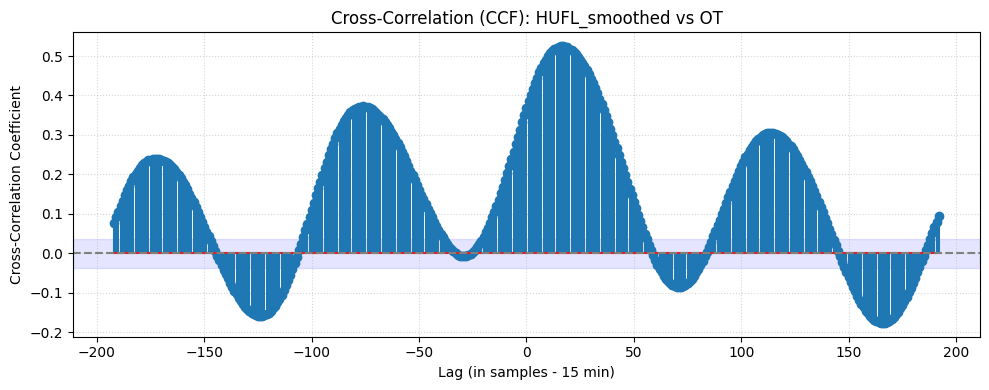

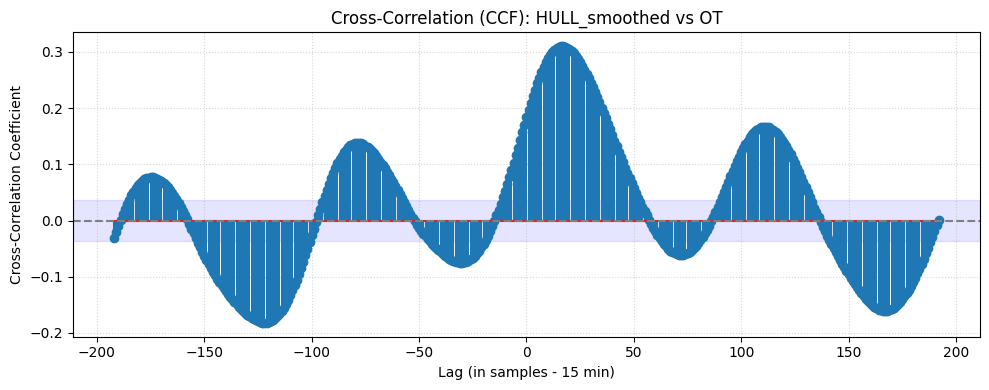

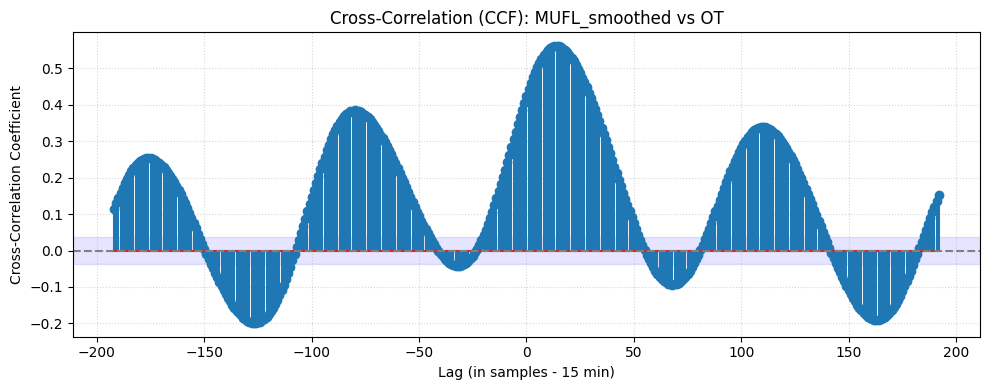

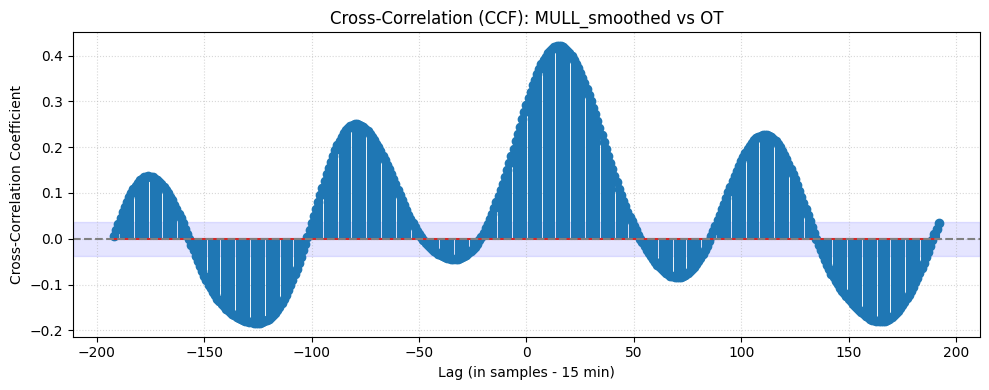

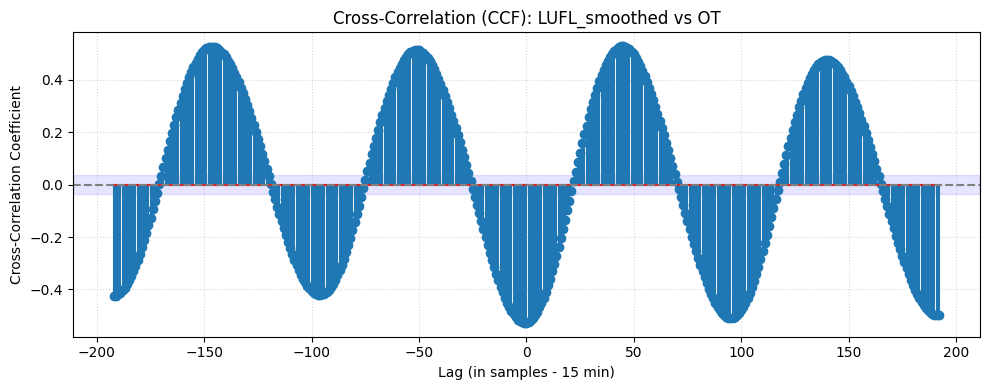

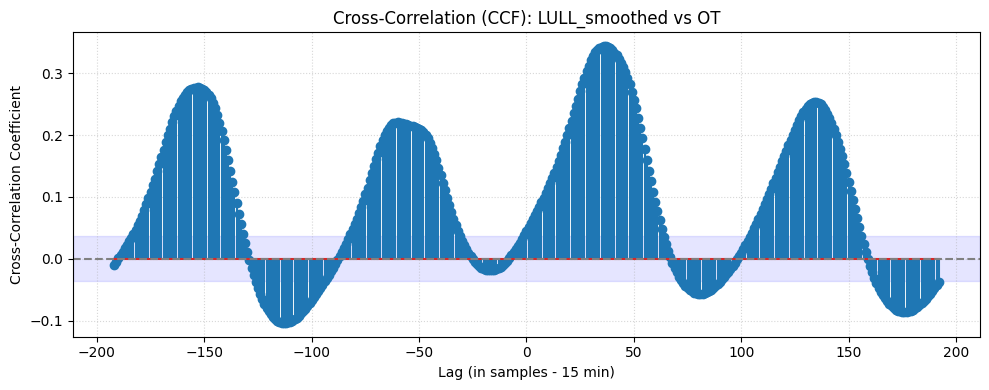

In [210]:

def plot_ccf(series_x, series_y, max_lags=20, feature_name='Feature', target_name='Target'):

    x = (series_x - np.mean(series_x)) / np.std(series_x)
    y = (series_y - np.mean(series_y)) / np.std(series_y)
    n = len(x)
    ccf = np.correlate(x, y, mode='full') / n

    lags = np.arange(-n + 1, n)
    center = np.argmax(lags == 0)
    start = center - max_lags
    end = center + max_lags + 1

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.stem(lags[start:end], ccf[start:end])
    ax.axhline(0.0, color='gray', linestyle='--')

    confidence_interval = 2 / np.sqrt(n)
    ax.axhspan(-confidence_interval, confidence_interval, color='blue', alpha=0.1)

    ax.set_title(f"Cross-Correlation (CCF): {feature_name} vs {target_name}")
    ax.set_xlabel(f"Lag (in samples - 15 min)")
    ax.set_ylabel("Cross-Correlation Coefficient")
    ax.grid(True, linestyle=':', alpha=0.5)

    plt.tight_layout()
    plt.show()

target_ot = df_month['OT'].values

features_to_test = ['HUFL_smoothed', 'HULL_smoothed', 'MUFL_smoothed', 'MULL_smoothed', 'LUFL_smoothed', 'LULL_smoothed']

for feature in features_to_test:
    feature_series = df_month[feature].values
    plot_ccf(feature_series, target_ot, max_lags=192, feature_name=feature, target_name='OT')

This code computes and plots the Cross-Correlation Function between each feature and the target to reveal lag relationships. This plot highlights a pattern in the data that we will use to create new features for the model. A common way to do this is to create lag features to highlight the seasonal pattern.

In [186]:
lag_features = df_cleaned[['MUFL_smoothed', 'LUFL_smoothed']].shift(192).add_suffix(f'_lag_{192}')
df_cleaned = pd.concat([df_cleaned, lag_features], axis=1)
df_cleaned = df_cleaned.dropna()

In [198]:
data_numeric = df_cleaned

In [199]:
data_numeric.columns

Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT', 'day_cos',
       'day_sin', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin',
       'minute_cos', 'minute_sin', 'HUFL_smoothed', 'HULL_smoothed',
       'MUFL_smoothed', 'MULL_smoothed', 'LUFL_smoothed', 'LULL_smoothed',
       'day', 'month', 'MUFL_smoothed_lag_192', 'LUFL_smoothed_lag_192'],
      dtype='object')

In [200]:
data_numeric = data_numeric[['OT', 'day_cos', 'day_sin', 'month_cos', 'month_sin', 'hour_cos',
       'hour_sin', 'minute_cos', 'minute_sin', 'HUFL_smoothed',
       'HULL_smoothed', 'MUFL_smoothed', 'MULL_smoothed', 'LUFL_smoothed',
       'LULL_smoothed','MUFL_smoothed_lag_192', 'LUFL_smoothed_lag_192']]

In [ ]:
seq_length = 96
pred_length = 96
batch_size = 32

cols_to_exclude = [col for col in data_numeric.columns if '_cos' in col or '_sin' in col]
train_loader, val_loader, test_loader, scaler, target_idx = create_loaders(data_numeric,seq_length=seq_length, pred_length=pred_length, batch_size=batch_size, target_col_name='OT',exclude_scale_cols=cols_to_exclude)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_batch = next(iter(train_loader))
input_size = sample_batch[0].shape[-1]

In [203]:
torch.manual_seed(45)
torch.cuda.manual_seed(45)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = PETNN(input_size=input_size,hidden_size=64,cell_dim=32,hard_switch=True,Rt_bias = 4.5 ,dropout= 0.4 , forecast_horizon=pred_length , head = 1.75).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
patience = 3
patience_counter = 0

for epoch_num in range(15):
    train_loss, val_loss, avg_releases = one_epoch(model, train_loader, val_loader, optimizer, criterion, device)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch_num + 1
        best_model_state = {'epoch': epoch_num + 1,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,'val_loss': val_loss,'avg_releases': avg_releases}
        torch.save(best_model_state, 'best_model.pth')
        patience_counter = 0
        print(f"New best!")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{patience})")

    print(f"Epoch {epoch_num+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Avg Releases={avg_releases:.2f}")
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch_num+1} epochs")
        break

print(f"\n=== Best model ===")
print(f"Epoch: {best_epoch}")
print(f"Train Loss: {best_model_state['train_loss']:.6f}")
print(f"Val Loss: {best_model_state['val_loss']:.6f}")

New best!
Epoch 1: Train=0.211614, Val=0.240675, Avg Releases=2678.00
New best!
Epoch 2: Train=0.163797, Val=0.197850, Avg Releases=2676.29
No improvement (1/3)
Epoch 3: Train=0.159121, Val=0.207663, Avg Releases=2664.21
No improvement (2/3)
Epoch 4: Train=0.157711, Val=0.232348, Avg Releases=2681.06
No improvement (3/3)
Epoch 5: Train=0.154865, Val=0.258046, Avg Releases=2713.06

Early stopping triggered after 5 epochs

=== Best model ===
Epoch: 2
Train Loss: 0.163797
Val Loss: 0.197850


In [ ]:
model.eval()
results = evaluate_model(model, test_loader, scaler, device)

## Model Performance

 * **Train Loss:** 0.1637
 * **Validation Loss:** 0.1978

 ---

## 📊 Test Set Evaluation

* **Mean of Residuals:** -0.77
* *Note: A non-zero mean indicates a systematic bias. The model consistently over-predicts by approximately 0.77 units, but this is significantly better than the -2.77 from the previous model.
* **MAE:** 3.30
* **MSE:** 19.50
* **RMSE:** 4.16

/tmp/ipython-input-4192988358.py:329: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


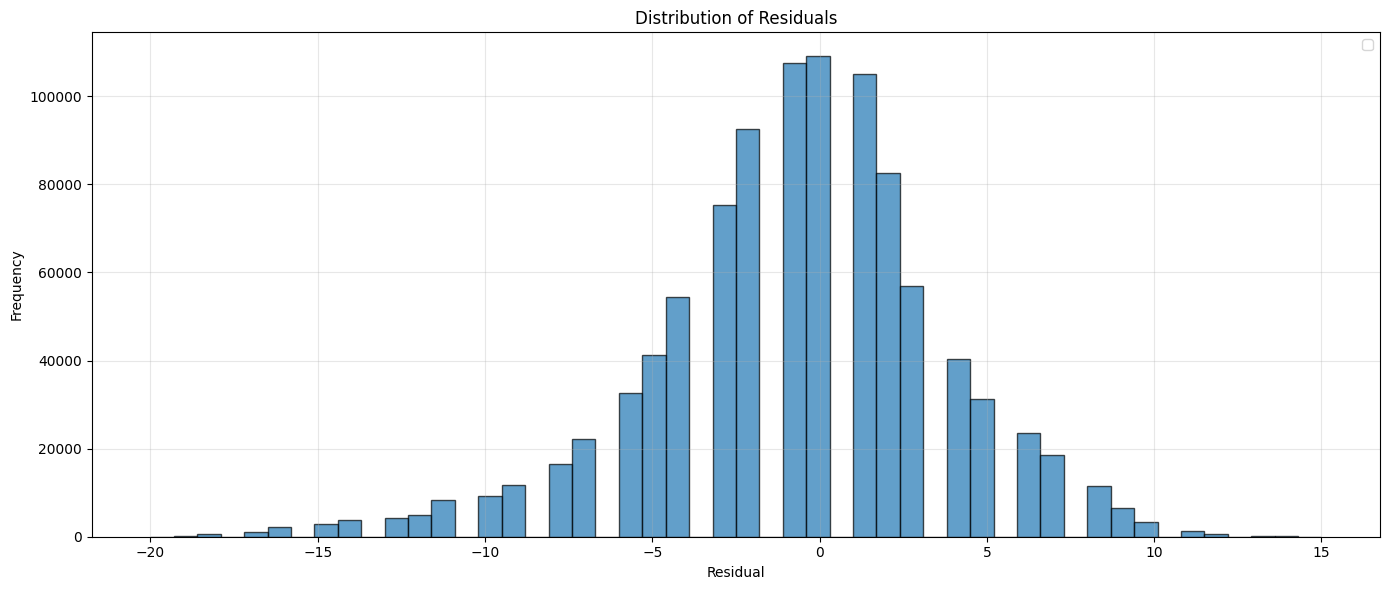

In [207]:
residuals = plot_residuals_distribution(results)

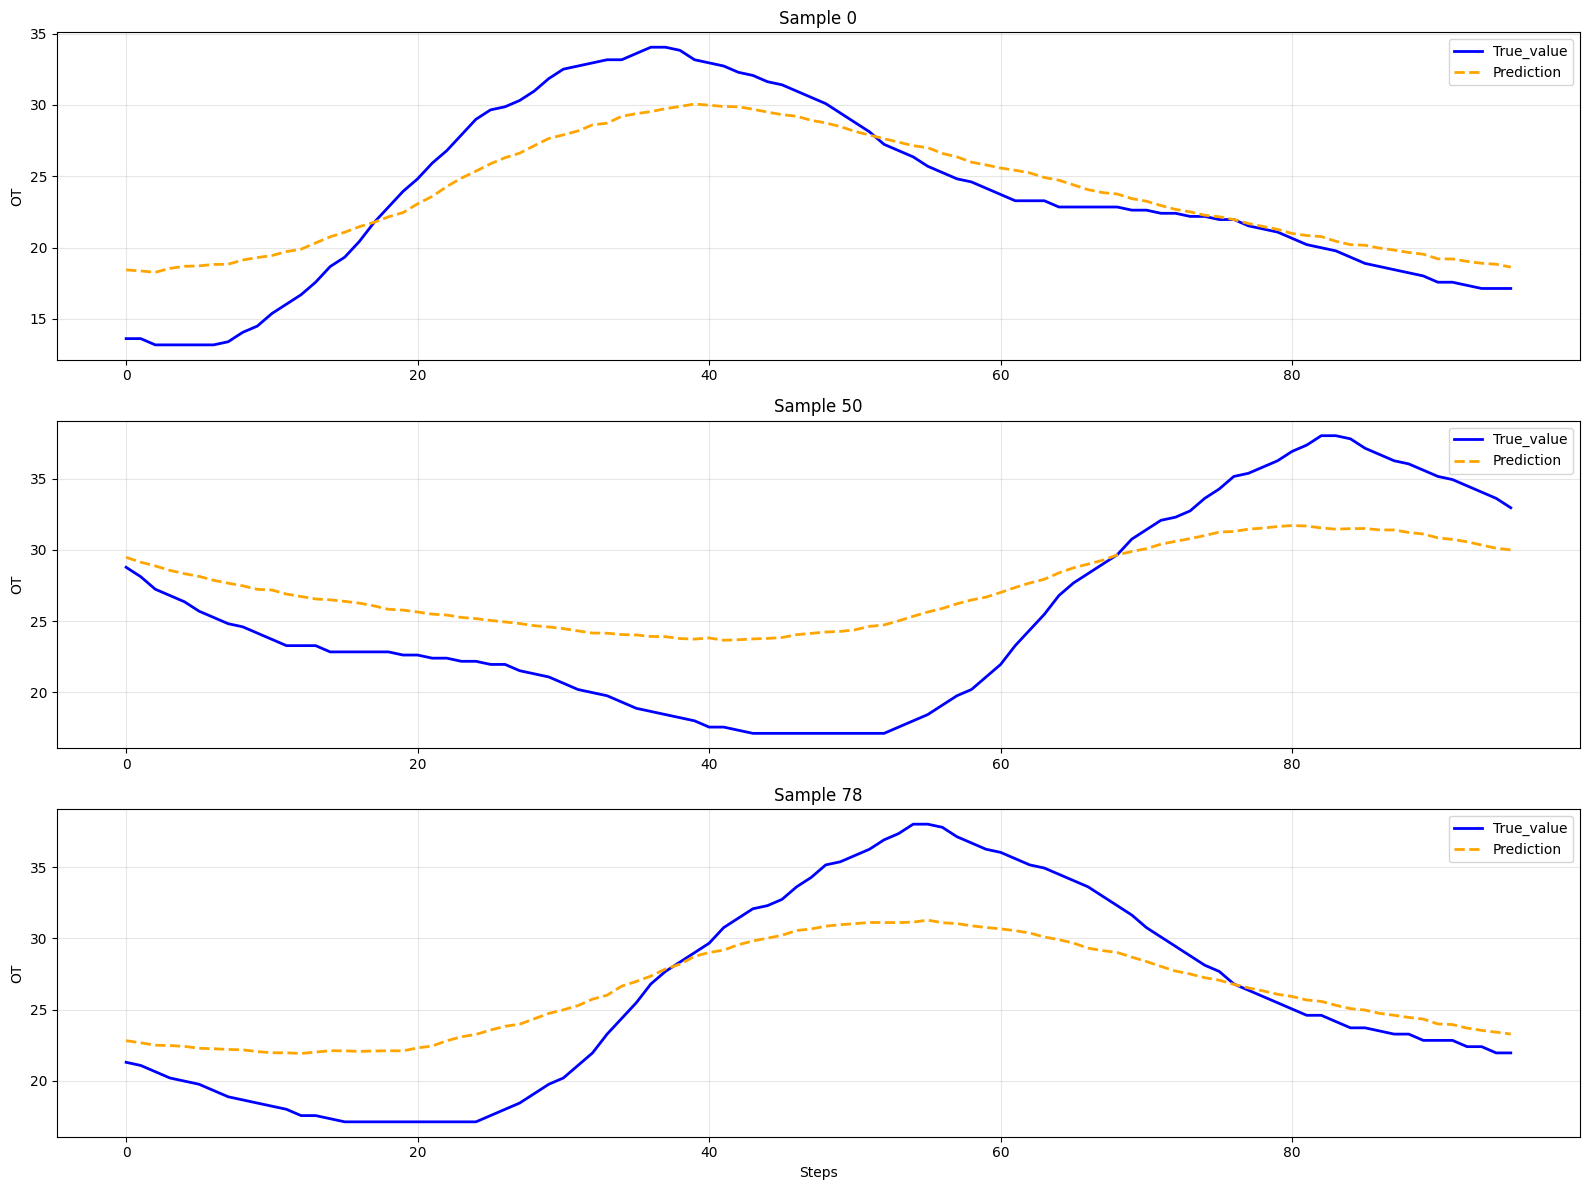

In [209]:
indices_to_plot = [0 , 50 , 78]

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for i, idx in enumerate(indices_to_plot):
    if idx >= len(results["targets"]):
        print(f"Warning: index {idx} out of range")
        continue

    sample_y = results["targets"][idx].flatten()
    sample_y_pred = results["predictions"][idx].flatten()

    axes[i].plot(range(len(sample_y)), sample_y, label='True_value', color='blue', linewidth=2)
    axes[i].plot(range(len(sample_y_pred)), sample_y_pred, label='Prediction', color='orange', linewidth=2, linestyle='--')
    axes[i].set_title(f"Sample {idx}", fontsize=12)
    axes[i].set_ylabel("OT")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

axes[2].set_xlabel("Steps")
plt.tight_layout()
plt.show()

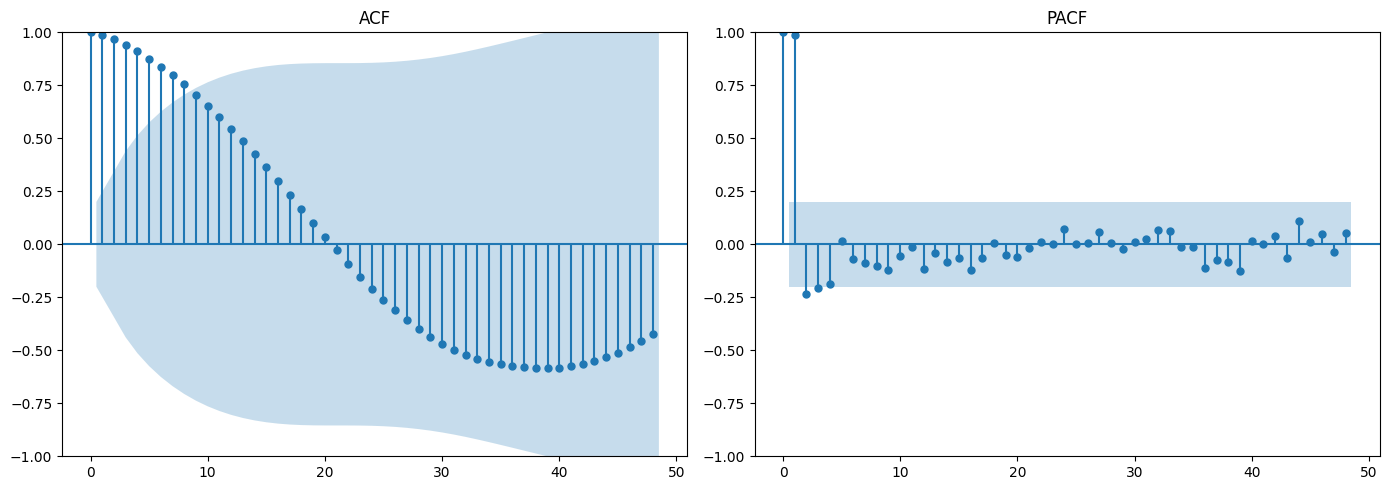

In [212]:

plot_autocorr_batch(results['predictions'], results['targets'])

## Final Result

The model has improved, but not as much as desired. This is due to a problem of model divergence. Perhaps I should bound `WZt`, `WZc`, and `WZw`, which could be the source of the problem. Even though the data is normalized, it's something I have to try.

In [ ]:
class PETNN_pen(nn.Module):
    def __init__(self, input_size, hidden_size, cell_dim=5, output_size=1, sequence_length=120, T_init=0.0, hard_switch=True, Rt_bias = 2.0 , It_bias=0.0 , Zt_bias = 1.0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell_dim = cell_dim if cell_dim is not None else hidden_size
        self.output_size = output_size
        self.sequence_length = sequence_length

        self.Rt_bias = Rt_bias
        self.It_bias = It_bias
        self.Zt_bias = Zt_bias

        self.T_init = T_init
        self.hard_switch = hard_switch

        self.WIt = nn.Linear(input_size, self.cell_dim)
        self.WRt = nn.Linear(input_size, 1)

        self.WZt = nn.Linear(input_size + hidden_size, 1)
        self.WZc = nn.Linear(input_size + hidden_size, self.cell_dim)
        self.WZw = nn.Linear(input_size + hidden_size, hidden_size)

        self.Wh = nn.Linear(input_size + hidden_size + self.cell_dim, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
                    if module == self.WRt:
                        nn.init.constant_(module.bias, self.Rt_bias)
                    elif module == self.WIt:
                      nn.init.constant_(module.bias, self.It_bias)
                    elif module == self.WZt:
                        nn.init.constant_(module.bias, self.Zt_bias)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        device = x.device

        S_prev = torch.zeros(batch_size, self.hidden_size, device=device)
        T_prev = torch.full((batch_size, 1), self.T_init, device=device)
        C_prev = torch.zeros(batch_size, self.cell_dim, device=device)

        total_resets = 0
        all_C_t = []
        for t in range(seq_len):
            X_t = x[:, t, :]
            if self.training:
                X_t = self.dropout1(X_t)

            S_prev, C_prev, T_prev, num_resets = self.update_step(X_t, S_prev, C_prev, T_prev)
            total_resets += num_resets
            all_C_t.append(C_prev)

        S_prev = self.batch_norm(S_prev)
        S_prev = self.dropout2(S_prev)

        output = self.out(S_prev)

        if self.hard_switch:
            #print(f"Number of energy releases: {total_resets}")
            return output.squeeze(-1), total_resets, all_C_t
        else:
            return output.squeeze(-1), 0, all_C_t

    def update_step(self, X_t, S_prev, C_prev, T_prev):
        It = self.WIt(X_t)
        Rt = self.WRt(X_t)

        concat_input = torch.cat([X_t, S_prev], dim=-1)
        Zt = self.WZt(concat_input)
        Zc = self.WZc(concat_input)
        Zw = self.WZw(concat_input)
        self.T_ground = 0.5

        T_new = Rt * torch.sigmoid((T_prev + Zt)) - 1

        num_resets = 0
        if self.hard_switch:
            m = (T_new < 0).float()
            num_resets = (T_new < 0).sum().item()
        else:
            m = torch.sigmoid(T_new)

        C_new = (1 - m) * C_prev + m * It + Zc

        C_modulated = (1 - m) * C_prev
        h_input = torch.cat([X_t, S_prev, C_modulated], dim=-1)
        h_state = torch.sigmoid(self.Wh(h_input))

        state_update = (1 - Zw) * S_prev + Zw * h_state
        S_new = torch.sigmoid(state_update)

        return S_new, C_new, T_new, num_resets